In [21]:
%matplotlib inline

In [22]:
import mne
import pathlib
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt, ticker, patheffects, colors

mne.viz.set_browser_backend("matplotlib")
plt.style.use("minimal.mplstyle")

In [23]:
RAW_DATA_PATH = pathlib.Path("../data/EEG")

SESSIONS = [
    "group13_a",
    "group13_b",
    "group13_c",
    "group13_d",
]

LFP_SMOOTHING = True

epochs_per_participant = {session.split("_")[-1]: mne.read_epochs(RAW_DATA_PATH.joinpath(session + ("_LPF_smoothed" if LFP_SMOOTHING else "") + "-epo.fif")) for session in SESSIONS}
all_epochs = mne.concatenate_epochs(list(epochs_per_participant.values()))

Reading /work/DanielAakjærLundgaard#0515/AuthorshipArtifice/analysis/../data/EEG/group13_a_LPF_smoothed-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
10025 matching events found
No baseline correction applied
0 projection items activated
Reading /work/DanielAakjærLundgaard#0515/AuthorshipArtifice/analysis/../data/EEG/group13_b_LPF_smoothed-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
6635 matching events found
No baseline correction applied
0 projection items activated
Reading /work/DanielAakjærLundgaard#0515/AuthorshipArtifice/analysis/../data/EEG/group13_c_LPF_smoothed-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
3173 matching events found
No baseline correction applied

/tmp/ipykernel_975/3766692705.py:13: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(list(epochs_per_participant.values()))


Not setting metadata
30843 matching events found
Applying baseline correction (mode: mean)
30843 matching events found
Applying baseline correction (mode: mean)


In [31]:
selected_participant = "a"

In [32]:
selected_contrasts = [
    {
        "Correct Keypress"              : ["correct"],
        "Incorrect Keypress"            : ["incorrect"],
    },
    {
        "Positive Feedback"             : ["correct", "error rectified"],
        "Negative Feedback"             : ["incorrect", "error inserted"],
    },
    {
        "Genuine Feedback"              : ["correct", "incorrect"],
        "Manipulated Feedback"          : ["error inserted", "error rectified"],
    },
    {
        "Inserted Error"                : ["error inserted"],
        "Rectified Error"               : ["error rectified"],
    },
    {
        "Genuine Positive Feedback"     : ["correct"],
        "Manipulated Positive Feedback" : ["error rectified"],
    },
    {
        "Genuine Negative Feedback"     : ["incorrect"],
        "Manipulated Negative Feedback" : ["error inserted"],
    },
]

---

# Comparing evoked GFPs

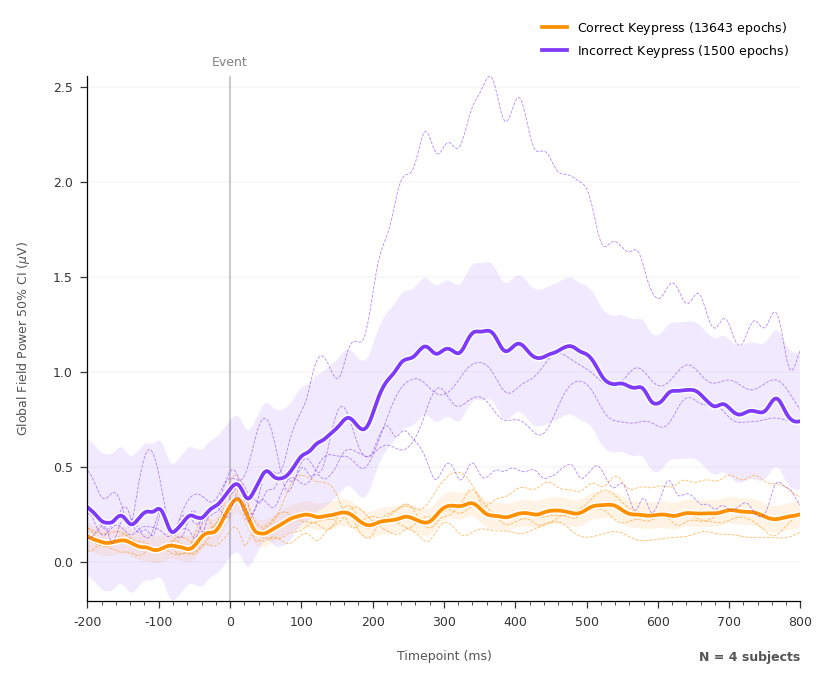

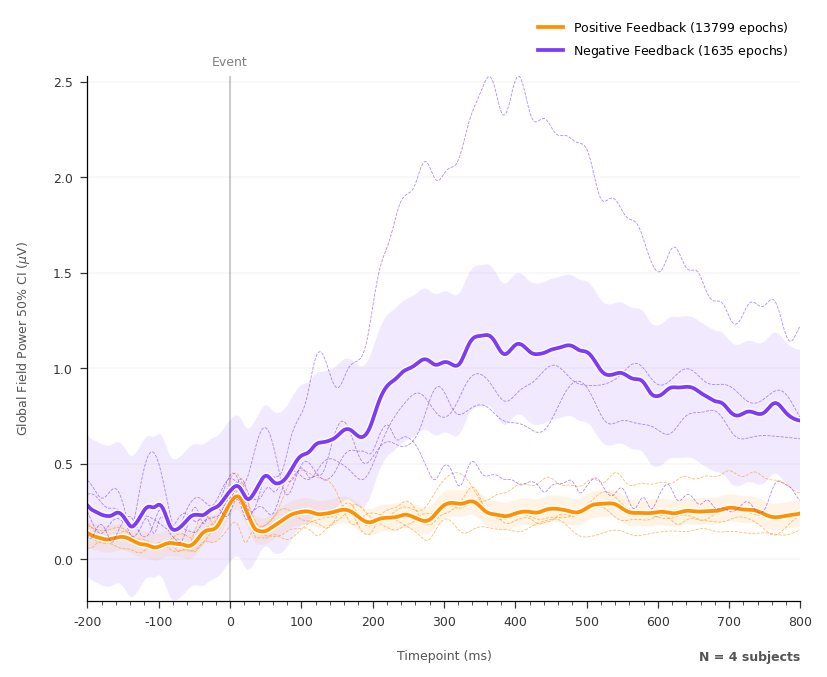

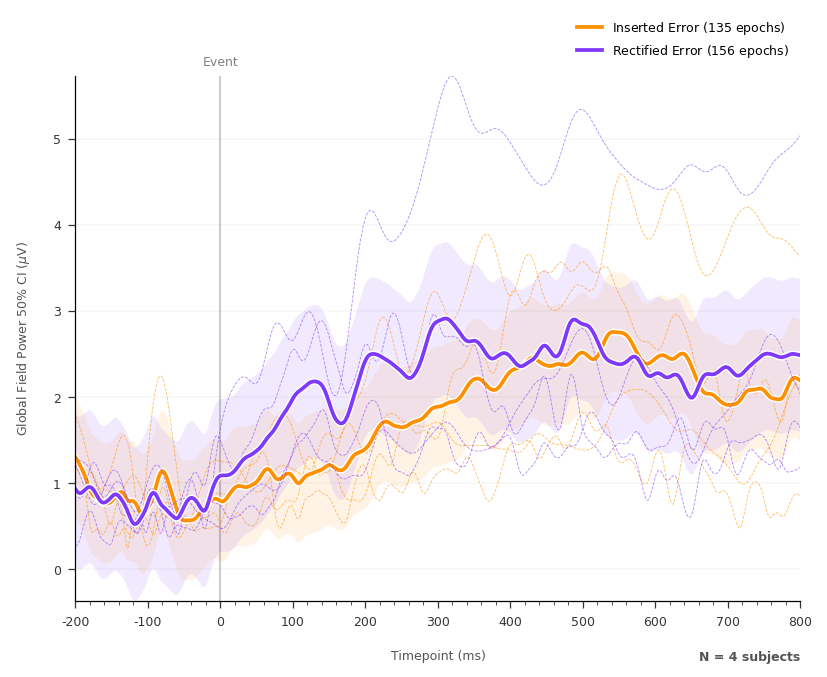

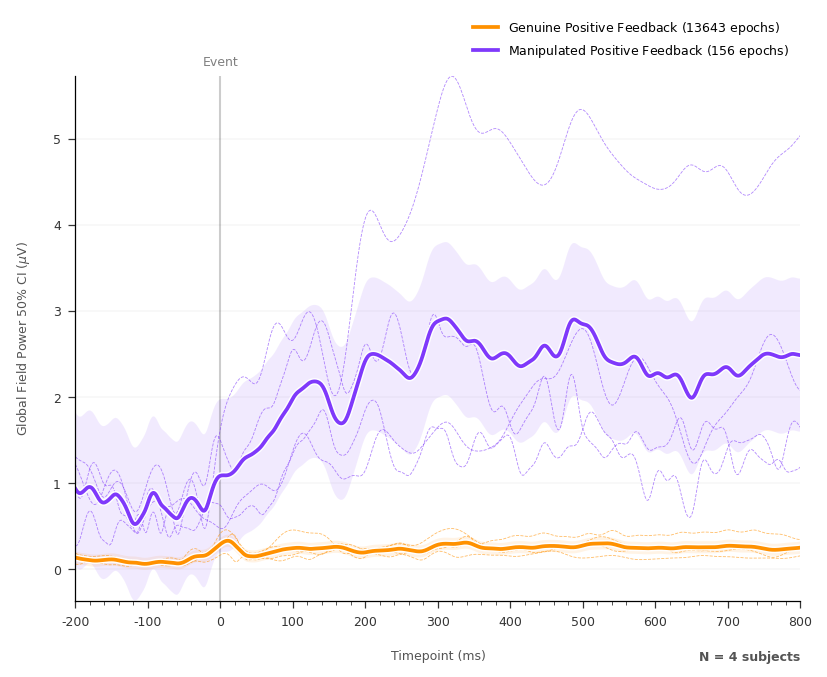

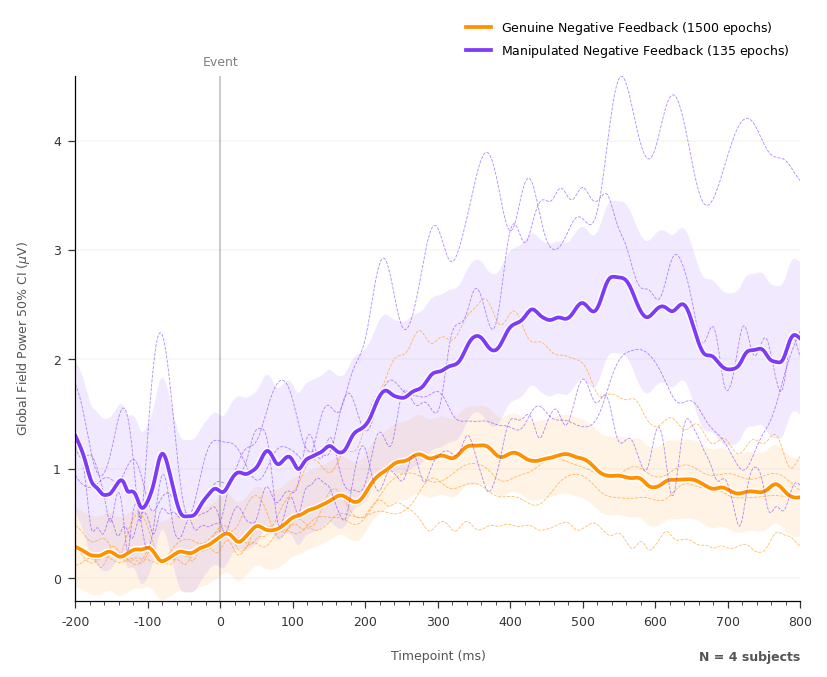

In [72]:
def compare_evoked_gfp(contrast, participant = None, channel_subset = None, ci = 0.5):
    fig, ax = plt.subplots(figsize = (5.4, 4.4))
    ax.axvline(
        x = 0, 
        color = "black",
        linewidth = 1,
        alpha = 0.2,
    )
    ax.annotate(
        "Event",
        xy = (0, 1.02),
        xycoords = ("data", "axes fraction"),
        ha = "center",
        alpha = 0.5,
    )
    ax.annotate(
        f"Participant {participant.upper()}" if participant else f"N = {len(epochs_per_participant)} subjects",
        xy = (1, 0.02),
        xycoords = ("axes fraction", "figure fraction"),
        fontweight = "bold",
        color = "#545454",
        ha = "right",
        va = "bottom"
    )

    for condition_index, (condition_name, events_identifiers) in enumerate(contrast.items()):
        per_participant = [epochs_per_participant[participant]] if participant else epochs_per_participant.values()
        signals = np.stack([epochs[events_identifiers].copy().pick(channel_subset, exclude = "bads").average().data * 1e6 for epochs in per_participant])

        for participant_signal in signals:
            signal_magnitude = participant_signal.std(axis = 0)
            ax.plot(
                all_epochs.times,
                signal_magnitude,
                color = f"C{condition_index + 1}", 
                linewidth = 0.4,
                linestyle = "dashed",
                alpha = 0.6, 
            )

        signal_magnitude = signals.std(axis = 1)
        ax.plot(
            all_epochs.times,
            signal_magnitude.mean(axis = 0),
            color = f"C{condition_index + 1}",
            linewidth = 1.8,
            path_effects = [patheffects.Stroke(linewidth = 3.2, foreground = "white"), patheffects.Normal()],
            label = f"{condition_name} (${len(all_epochs[events_identifiers])}$ epochs)"
        )
        ax.fill_between(
            all_epochs.times, 
            *stats.norm.interval(ci, loc=signal_magnitude.mean(axis = 0), scale = signal_magnitude.std()),
            color = f"C{condition_index + 1}", 
            alpha=0.1,
            edgecolor = "none"
        )

    ax.legend(
        loc = "lower right", 
        bbox_to_anchor = (1, 1.01),
    )

    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
    ax.xaxis.set_major_formatter(lambda sec, idx: round(sec * 1000))
    ax.set_xlabel("Timepoint (ms)")
    ax.set_ylabel(f"Global Field Power {ci:.0%} CI ($\\mu$V)")
    ax.margins(y = 0)
    plt.show()

for contrast in selected_contrasts[:2] + selected_contrasts[3:]:
    # compare_evoked_gfp(contrast, participant=selected_participant)
    compare_evoked_gfp(contrast)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 30


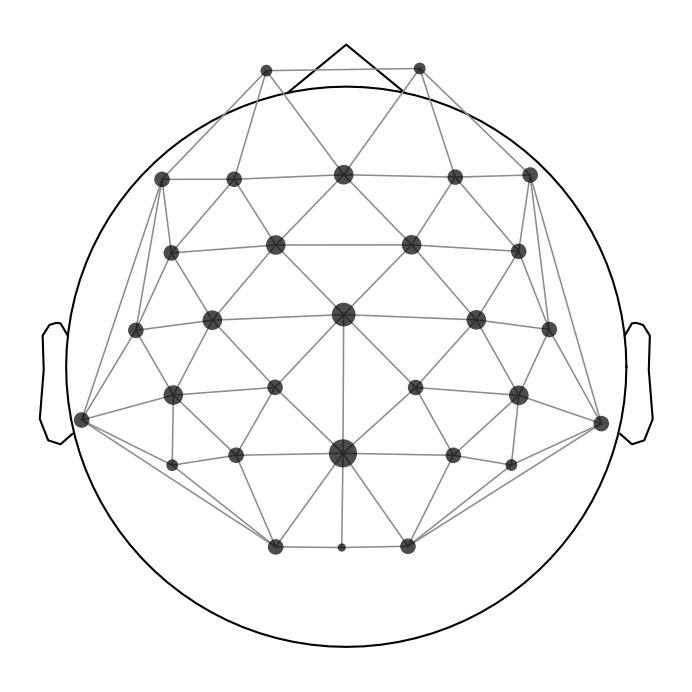

In [34]:
adjacency, ch_names = mne.channels.find_ch_adjacency(all_epochs.info, ch_type="eeg")
mne.viz.plot_ch_adjacency(all_epochs.info, adjacency, ch_names);

# Cluster-based permutation analysis

stat_fun(H1): min=0.000000 max=15.206334


Running initial clustering …
Found 22 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

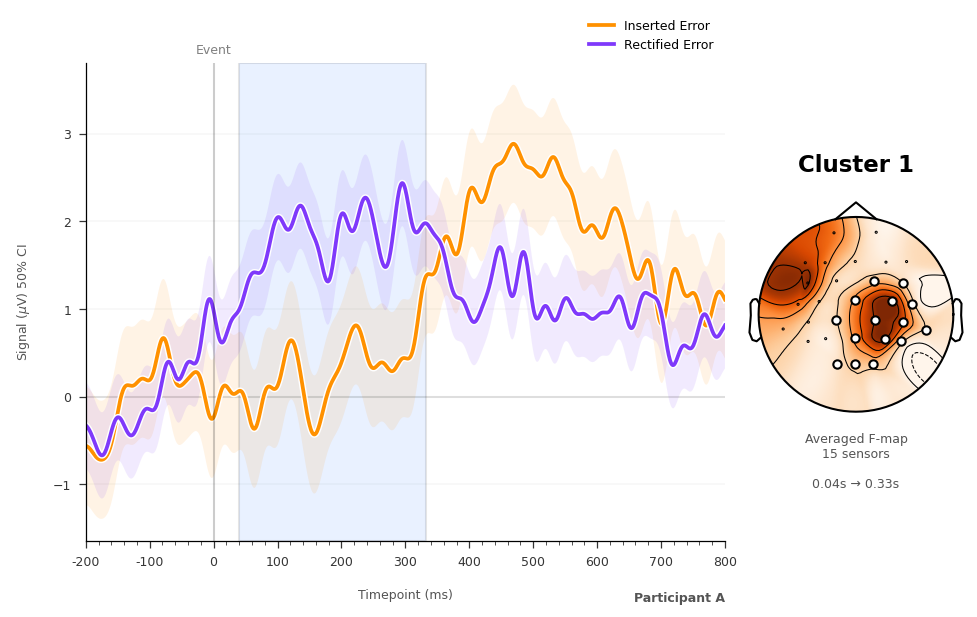

In [71]:
def perform_cluster_permutation(participant, conditions, clustering_alpha = 0.05, p_threshold = 0.05, ci = 0.5):
    epochs = epochs_per_participant[participant]

    transposed_data = [np.transpose(epochs[condition].get_data(copy = True), (0, 2, 1)) for condition in conditions.values()] 

    F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(
        X = transposed_data,
        n_permutations=500, 
        adjacency=adjacency, 
        tail = 0,
        threshold = stats.f.ppf(
            1 - clustering_alpha, 
            dfn=len(conditions) - 1, 
            dfd=(sum([len(cond) for cond in transposed_data]) / len(conditions))  - len(conditions),
        ),
        n_jobs=-1, 
        seed=0,
    )

    selected_clusters = [cluster for cluster, p_val in zip(clusters, p_values) if p_val < p_threshold]
    if not len(selected_clusters):
        print("No clusters reached set significance threshold of", p_threshold)
    else:
        for cluster_id, cluster in enumerate(selected_clusters, start = 1):
            time_inds, space_inds = np.squeeze(cluster)
            ch_inds = np.unique(space_inds)
            time_inds = np.unique(time_inds)

            f_map = F_obs[time_inds, ...].mean(axis=0) # topography for stats
            sig_times = epochs.times[time_inds] # signals at the sensors contributing to the cluster

            mask = np.zeros((f_map.shape[0], 1), dtype=bool) # creating spatial mask
            mask[ch_inds, :] = True

            fig, (ax_signals, ax_topography) = plt.subplots(
                ncols = 2, 
                figsize=(6.4, 4), 
                width_ratios = [0.75, 0.25], 
            )
            ax_topography.set_title(f"Cluster {cluster_id}")

            mne.viz.plot_topomap(
                f_map,
                epochs.info,
                axes=ax_topography,
                cmap="Oranges",
                sphere=(0, 0, 0, 0.12),
                show=False,
                mask=mask
            )

            ax_topography.set_xlabel(f"Averaged F-map\n{len(ch_inds)} sensors\n\n{sig_times[0]:.2f}s → {sig_times[-1]:.2f}s")

            ax_signals.axhline(
                y = 0, 
                color = "black",
                linewidth = 1,
                alpha = 0.1
            )
            ax_signals.axvspan(
                sig_times[0], 
                sig_times[-1], 
                facecolor="C6", 
                edgecolor="black", 
                alpha=0.1
            )
            for condition_index, (condition, cluster_signal) in enumerate(zip(conditions.keys(), transposed_data)):
                signal = cluster_signal[:, :, ch_inds].mean(axis=(0, 2)) * 1e6
                ax_signals.plot(
                    epochs.times, 
                    signal,
                    label=condition,
                    color = f"C{condition_index + 1}",
                    linewidth = 1.8,
                    path_effects = [patheffects.Stroke(linewidth = 3.2, foreground = "white"), patheffects.Normal()],
                )
                ax_signals.fill_between(
                    epochs.times, 
                    *stats.norm.interval(ci, loc=signal, scale = signal.std()),
                    color = f"C{condition_index + 1}", 
                    alpha=0.1,
                    edgecolor = "none"
                )
            ax_signals.legend(loc = "lower right", bbox_to_anchor = (1, 1))
            ax_signals.set_ylabel(f"Signal ($\\mu$V) {ci:.0%} CI")
            ax_signals.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
            ax_signals.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
            ax_signals.xaxis.set_major_formatter(lambda sec, idx: round(sec * 1000))
            ax_signals.set_xlabel("Timepoint (ms)")
            ax_signals.axvline(
                x = 0, 
                color = "black",
                linewidth = 1,
                alpha = 0.2,
            )
            ax_signals.annotate(
                "Event",
                xy = (0, 1.02),
                xycoords = ("data", "axes fraction"),
                ha = "center",
                alpha = 0.5,
            )
            ax_signals.annotate(
                f"Participant {participant.upper()}",
                xy = (1, 0.02),
                xycoords = ("axes fraction", "figure fraction"),
                fontweight = "bold",
                color = "#545454",
                ha = "right",
                va = "bottom"
            )

            plt.show()

if selected_participant:
    for contrast in [selected_contrasts[3]]:
        perform_cluster_permutation(
            participant = selected_participant,
            conditions = contrast,
        )

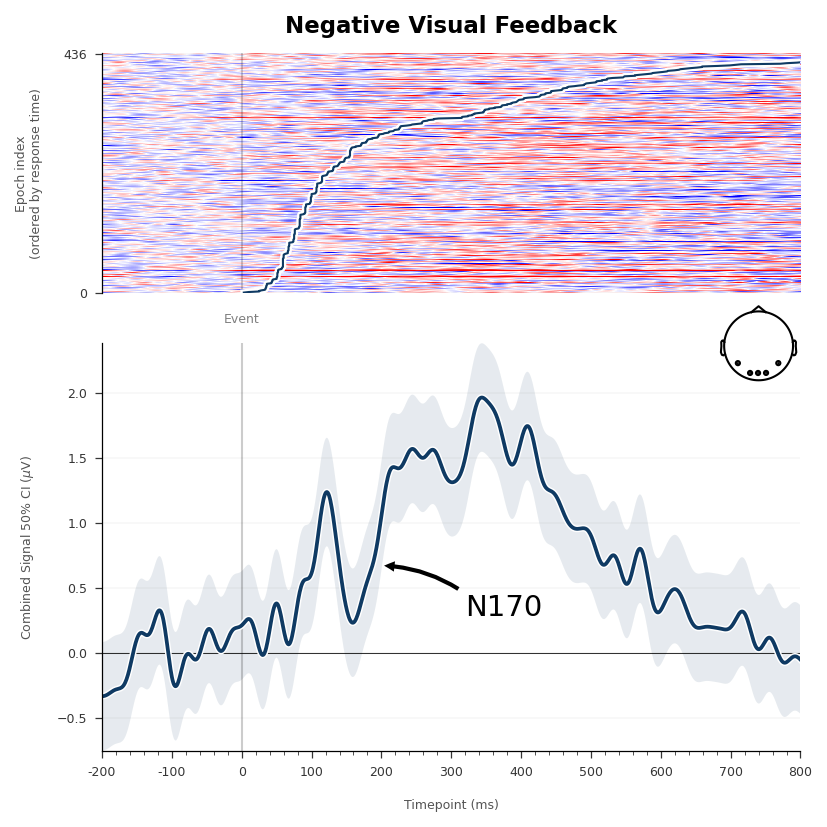

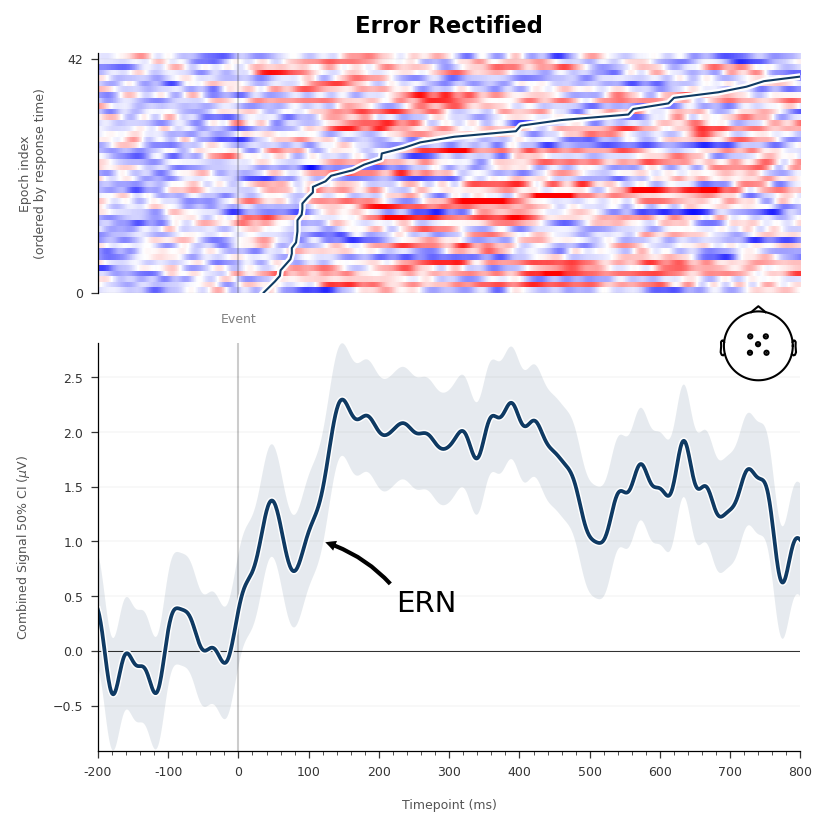

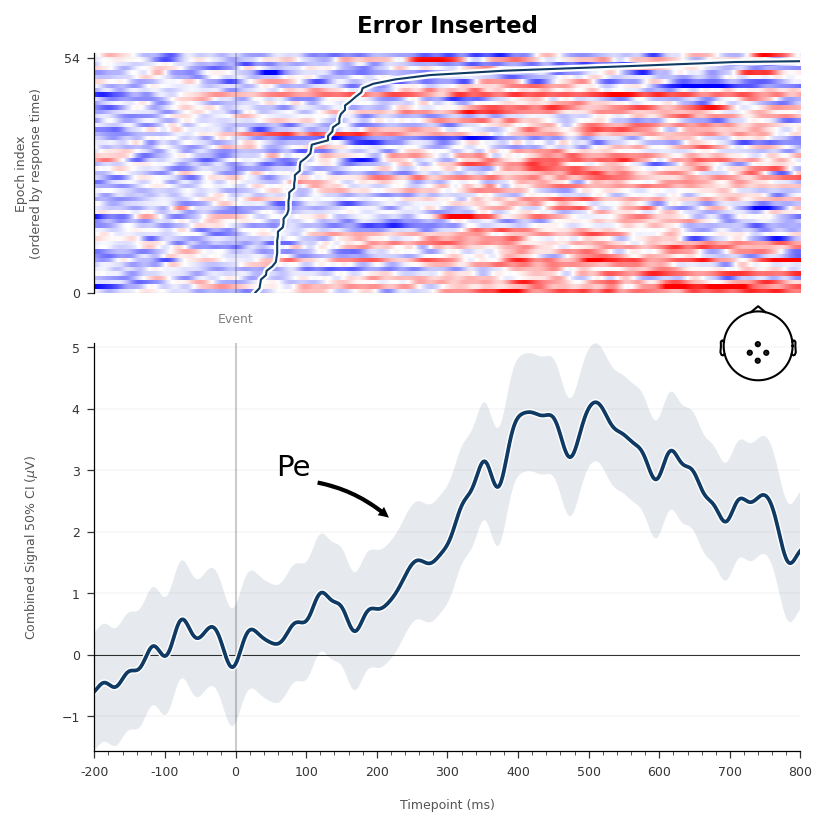

In [70]:
def sanity_check(conditions, participant = None, channels = None, title = None, annotation = None, ci = 0.5, scale = 25):
    epochs = epochs_per_participant[participant] if participant else all_epochs
    evokeds = epochs[conditions].copy().pick(channels)
    data = evokeds._get_data().mean(axis = 1) * 1e6

    fig, axes = plt.subplots(
        figsize = (5.4, 5.4), 
        nrows = 2, 
        height_ratios = [0.37, 0.63],
        layout="constrained",
        gridspec_kw = dict(hspace=0),
    )
    ax_epochs, ax_signal = axes

    if title:
        ax_epochs.set_title(title)

    for ax in axes:
        ax.axvline(
            x = 0, 
            color = "black",
            linewidth = 1,
            alpha = 0.2,
        )
    ax_signal.axhline(
        y = 0, 
        color = "black",
        linewidth = 0.5,
        alpha = 0.8,
    )
    ax_signal.annotate(
        "Event",
        xy = (0, 1.05),
        xycoords = ("data", "axes fraction"),
        ha = "center",
        alpha = 0.5,
    )

    signal_mean = data.mean(axis = 0)
    ax_signal.plot(
        evokeds.times,
        signal_mean,
        linewidth = 1.8,
        path_effects = [patheffects.Stroke(linewidth = 3.2, foreground = "white"), patheffects.Normal()],
    )
    ax_signal.fill_between(
        all_epochs.times, 
        *stats.norm.interval(ci, loc=signal_mean, scale = signal_mean.std()),
        alpha=0.1,
        edgecolor = "none"
    )

    ax_epochs.set_xticks([])
    ax_epochs.set_yticks([0, len(evokeds) - 1])
    ax_epochs.spines["bottom"].set_visible(False)
    ax_signal.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax_signal.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
    ax_signal.xaxis.set_major_formatter(lambda sec, idx: round(sec * 1000))
    ax_signal.set_xlabel("Timepoint (ms)")
    ax_signal.set_ylabel(("Combined " if channels and len(channels) > 1 else "") + f"Signal {ci:.0%} CI ($\\mu$V)")
    ax_signal.margins(y = 0)

    if annotation:
        ax_signal.annotate(
            annotation["caption"],
            xy=annotation["point"], 
            xycoords="data",
            xytext=annotation["offset"],
            textcoords="offset points",
            arrowprops=dict(
                width = 2,
                headwidth = 5,
                headlength = 5,
                facecolor = "black", 
                edgecolor = "none",
                shrink = 0.03,
                connectionstyle=f"""arc3,rad={annotation["arc"]}""",
            ),
            fontsize = 14,
            ha = "left",
            va = "center",
        )

    all_events = all_epochs.events
    intervals = []
    for evoked_timepoint, _, _ in evokeds.events:
        following_events = all_events[all_events[:, 0] > evoked_timepoint]
        following_keypresses = following_events[following_events[:, 2] == 1]
        timepoint_of_next_keypress = following_keypresses[0][0]
        intervals.append((timepoint_of_next_keypress - evoked_timepoint) / 1e3)

    data = data[np.argsort(intervals),:]
    ax_epochs.imshow(
        (data - data.mean()) / data.std(),
        origin = "lower",
        interpolation = "nearest",
        aspect = "auto",
        cmap = "bwr",
        vmin = -3,
        vmax = 3,
        extent = [evokeds.times[0], evokeds.times[-1], 0, len(intervals)]
    )
    ax_epochs.plot(
        np.sort(intervals),
        np.arange(len(intervals)),
        linewidth = 1,
        color = "C0",
        path_effects = [patheffects.Stroke(linewidth = 3.2, foreground = "white"), patheffects.Normal()],
    )
    ax_epochs.set_xlim(evokeds.times[0], evokeds.times[-1])
    ax_epochs.set_ylabel("Epoch index\n(ordered by response time)")

    ax_topo = ax_signal.inset_axes([0.84, 0.9, 0.2, 0.2], in_layout = False)
    mne.viz.plot_sensors(
        evokeds.info,
        axes = ax_topo,
        pointsize = 1,
        sphere=(0, 0.02, 0, 0.1),
    )
    ax_topo.axis("off")

    plt.show()

sanity_check(
    participant = selected_participant,
    conditions = ["incorrect", "error inserted"], 
    title = "Negative Visual Feedback",
    channels = ["O1", "Oz", "O2", "P7", "P8"],
    annotation = dict(caption = "N170", point = (0.2, 0.67), offset = (40, -20), arc = 0.15)
)

sanity_check(
    participant = selected_participant,
    conditions = ["error rectified"], 
    title = "Error Rectified",
    channels = ["Cz", "CP1", "CP2", "FC1", "FC2"],
    annotation = dict(caption = "ERN", point = (0.12, 1.0), offset = (35, -30), arc = 0.15)
)

sanity_check(
    participant = selected_participant,
    conditions = ["error inserted"], 
    title = "Error Inserted",
    channels = ["Cz", "CP1", "CP2", "Pz"],
    annotation = dict(caption = "Pe", point = (0.22, 2.2), offset = (-55, 25), arc = -0.15)
)

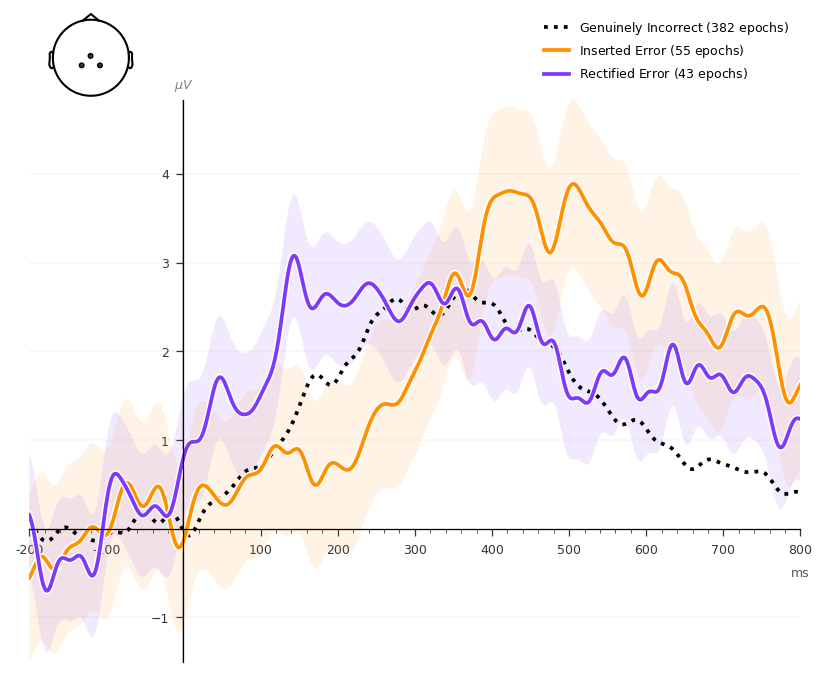

In [77]:
def compare_conditions(contrast, waveform_reference, channel_subset, participant = None, ci = 0.5):
    fig, ax = plt.subplots(figsize = (5.4, 4.4))

    ax.axvline(
        x = 0, 
        color = "black",
        linewidth = 1,
        alpha = 0.2,
    )
    ax.annotate(
        "$\mu V$",
        xy = (0, 1.02),
        xycoords = ("data", "axes fraction"),
        ha = "center",
        alpha = 0.5,
    )
    ax.axhline(
        y = 0, 
        color = "black",
        linewidth = 0.5,
        alpha = 0.8,
    )

    epochs = epochs_per_participant[participant] if participant else all_epochs

    per_participant = [epochs_per_participant[participant]] if participant else epochs_per_participant.values()
    reference_signal = np.stack([epochs[waveform_reference[1]].copy().pick(channel_subset, exclude = "bads").average().data * 1e6 for epochs in per_participant]).mean(axis = (0, 1))
    ax.plot(
        epochs.times,
        reference_signal,
        color = "black",
        linewidth = 1.8,
        linestyle = "dotted",
        label = f"{waveform_reference[0]} (${len(epochs[waveform_reference[1]])}$ epochs)"
    )

    for condition_index, (condition_name, events_identifiers) in enumerate(contrast.items()):
        per_participant = [epochs_per_participant[participant]] if participant else epochs_per_participant.values()
        signals = np.stack([epochs[events_identifiers].copy().pick(channel_subset, exclude = "bads").average().data * 1e6 for epochs in per_participant])

        for participant_signal in signals:
            signal_magnitude = participant_signal.mean(axis = 0)
            ax.plot(
                all_epochs.times,
                signal_magnitude,
                color = f"C{condition_index + 1}", 
                linewidth = 0.4,
                linestyle = "dashed",
                alpha = 0.6, 
            )

        signal_magnitude = signals.mean(axis = (0, 1))
        ax.plot(
            epochs.times,
            signal_magnitude,
            color = f"C{condition_index + 1}",
            linewidth = 1.8,
            path_effects = [patheffects.Stroke(linewidth = 3.2, foreground = "white"), patheffects.Normal()],
            label = f"{condition_name} (${len(epochs[events_identifiers])}$ epochs)"
        )
        ax.fill_between(
            epochs.times, 
            *stats.norm.interval(ci, loc=signal_magnitude, scale = signals.std()),
            color = f"C{condition_index + 1}", 
            alpha=0.1,
            edgecolor = "none"
        )

    ax.legend(
        loc = "lower right", 
        bbox_to_anchor = (1, 1.01),
    )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
    ax.xaxis.set_major_formatter(lambda sec, idx: round(sec * 1000))
    ax.xaxis.set_ticks([tick for tick in ax.get_xticks() if not tick == 0])
    ax.yaxis.set_ticks([tick for tick in ax.get_yticks() if not tick == 0])
    ax.set_xlabel("ms", x = 1, ha = "center", labelpad = 5)
    ax.set_xlim(epochs.times[0], epochs.times[-1])
    ax.margins(x = 0, y = 0)
    ax.spines[["left", "bottom"]].set_position("zero")

    ax_topo = ax.inset_axes([0, 1, 0.16, 0.16], in_layout = False)
    mne.viz.plot_sensors(
        epochs.copy().pick(channel_subset).info,
        axes = ax_topo,
        pointsize = 0.8,
        sphere=(0, 0.02, 0, 0.1),
    )
    ax_topo.axis("off")

    plt.show()

compare_conditions(
    participant = selected_participant, 
    contrast = selected_contrasts[3],
    waveform_reference = ("Genuinely Incorrect", ["incorrect"]),
    channel_subset = ["Cz", "CP1", "CP2"],
)


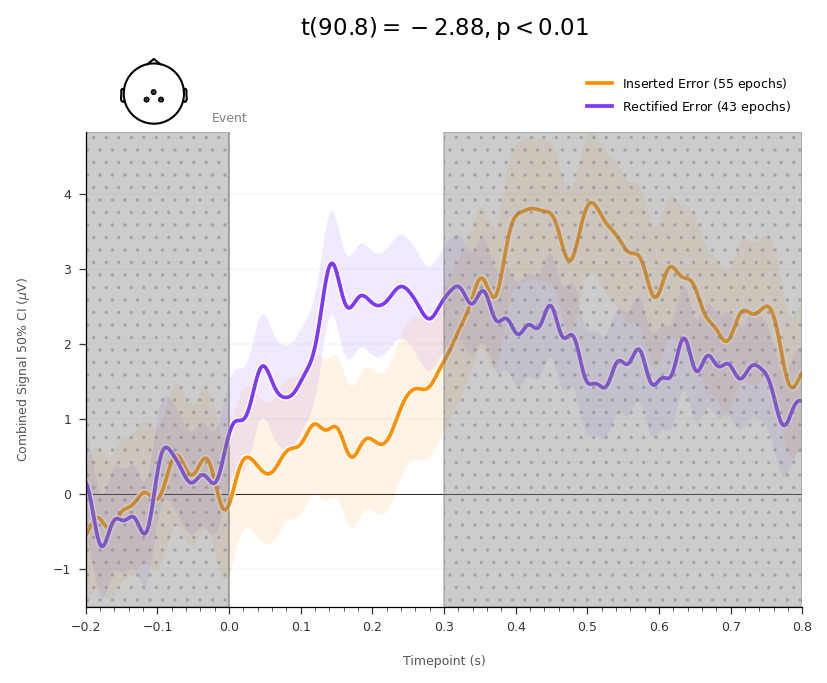

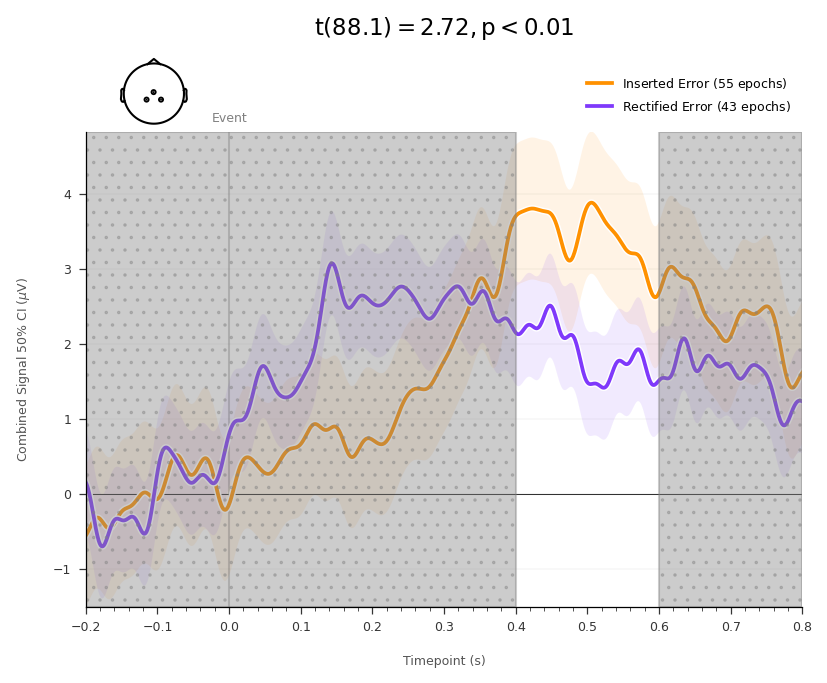

In [38]:
def windowed_mean_test(contrast, channel_subset, time_begin, time_end, participant = None, title = "", ci = 0.5, p_threshold = 0.01):
    fig, ax = plt.subplots(figsize = (5.4, 4.4))

    ax.axvline(
        x = 0, 
        color = "black",
        linewidth = 1,
        alpha = 0.2,
    )
    ax.annotate(
        "Event",
        xy = (0, 1.02),
        xycoords = ("data", "axes fraction"),
        ha = "center",
        alpha = 0.5,
    )
    ax.axhline(
        y = 0, 
        color = "black",
        linewidth = 0.5,
        alpha = 0.8,
    )

    epochs = epochs_per_participant[participant] if participant else all_epochs
    for condition_index, (condition_name, events_identifiers) in enumerate(contrast.items()):
        per_participant = [epochs_per_participant[participant]] if participant else epochs_per_participant.values()
        signals = np.stack([epochs[events_identifiers].copy().pick(channel_subset, exclude = "bads").average().data * 1e6 for epochs in per_participant])

        for participant_signal in signals:
            signal_magnitude = participant_signal.mean(axis = 0)
            ax.plot(
                all_epochs.times,
                signal_magnitude,
                color = f"C{condition_index + 1}", 
                linewidth = 0.4,
                linestyle = "dashed",
                alpha = 0.6, 
            )

        signal_magnitude = signals.mean(axis = (0, 1))
        ax.plot(
            epochs.times,
            signal_magnitude,
            color = f"C{condition_index + 1}",
            linewidth = 1.8,
            path_effects = [patheffects.Stroke(linewidth = 3.2, foreground = "white"), patheffects.Normal()],
            label = f"{condition_name} (${len(epochs[events_identifiers])}$ epochs)"
        )
        ax.fill_between(
            epochs.times, 
            *stats.norm.interval(ci, loc=signal_magnitude, scale = signals.std()),
            color = f"C{condition_index + 1}", 
            alpha=0.1,
            edgecolor = "none"
        )

    ax.axvspan(
        epochs.times[0], 
        time_begin, 
        facecolor="grey", 
        edgecolor="grey", 
        hatch = "..",
        alpha=0.4,
        zorder = 2,
    )
    ax.axvspan(
        time_end, 
        epochs.times[-1], 
        facecolor="grey", 
        edgecolor="grey", 
        hatch = "..",
        alpha=0.4,
        zorder = 2,
    )

    ax.legend(
        loc = "lower right", 
        bbox_to_anchor = (1, 1.01),
    )

    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
    ax.xaxis.set_major_formatter(lambda sec, idx: round(sec * 1000))
    ax.set_xlabel("Timepoint (ms)")
    ax.set_ylabel(("Combined " if channel_subset and len(channel_subset) > 1 else "") + f"Signal {ci:.0%} CI ($\\mu$V)") 
    ax.set_xlim(epochs.times[0], epochs.times[-1])
    ax.margins(x = 0, y = 0)

    if participant:
        t_test_result = stats.ttest_ind(
            *[epochs[condition].get_data(picks = channel_subset, tmin = time_begin, tmax = time_end).mean(axis=(1, 2)) * 1e6 for condition in contrast.values()],
            equal_var = False,
        )
    else:
        t_test_result = stats.ttest_rel(
            *[[participant_epochs[condition].get_data(picks = channel_subset, tmin = time_begin, tmax = time_end).mean(axis=(0, 1, 2)) * 1e6 for participant_epochs in epochs_per_participant.values()] for condition in contrast.values()]
        )
    formatted_t_test_resulted = r"\mathrm{t}" + f"({str(round(t_test_result.df, 1)).rstrip('.0')}) = {t_test_result.statistic:.2f}" + ", " + r"\mathrm{p}" + f"{'=' if t_test_result.pvalue >= p_threshold else '<'} {p_threshold if t_test_result.pvalue < p_threshold else t_test_result.pvalue:.2f}"
    output = title
    output += "\n"
    output += ", ".join(channel_subset) 
    output += " "
    output += f"from {time_begin:.2f}s until {time_end:.2f}s"
    output += "\n"
    output += formatted_t_test_resulted
    # print(output)

    ax.set_title("$" + formatted_t_test_resulted + "$")

    ax_topo = ax.inset_axes([0.02, 1.01, 0.15, 0.15], in_layout = False)
    mne.viz.plot_sensors(
        epochs.copy().pick(channel_subset).info,
        axes = ax_topo,
        pointsize = 0.8,
        sphere=(0, 0.02, 0, 0.1),
    )
    ax_topo.axis("off")
    plt.show()

windowed_mean_test(
    participant = selected_participant, 
    contrast = selected_contrasts[3],
    channel_subset = ["Cz", "CP1", "CP2"],
    time_begin = 0.00,
    time_end = 0.30,
)

windowed_mean_test(
    participant = selected_participant,
    contrast = selected_contrasts[3],
    channel_subset = ["Cz", "CP1", "CP2"],
    time_begin = 0.40,
    time_end = 0.60,
)